# Exercício 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math 
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.special import erfc

In [2]:
def mod(V):
    ip = np.zeros((len(V),1),dtype=complex)
    inc = 0
    for v in V:
        if(v==0):
            ip[inc] = -1.0 - 1j*1.0
        elif(v==1):
            ip[inc] = -1.0 + 1j*1.0
        elif(v==2):
            ip[inc] = 1.0 - 1j*1.0
        else:
            ip[inc] = 1.0 + 1j*1.0
        inc += 1
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    return s

def demod(c):
    c_seq = mod(np.array([0,1,2,3]))
    c_seq = c_seq[:,0]
    e = []
    for i in range(0,len(c_seq)):
        e.append(np.abs(c_seq[i] - c)**2)
    return e.index(np.min(e))

In [3]:
# Number of BPSK symbols to be transmitted.
N = 1000000

In [4]:
# Create Es/N0 vector.
EsN0dB = np.arange(-2,22,2)

ser_simu = np.zeros(len(EsN0dB))
ser_theo = np.zeros(len(EsN0dB))

n_clusters=2
km_re = KMeans(n_clusters=n_clusters)

km_im = KMeans(n_clusters=n_clusters)

ber_theo = ber_simu = np.zeros(len(EsN0dB))
for idx in range(0,len(EsN0dB)):    

    EsN0Lin = 10.0**(-(EsN0dB[idx]/10.0))
    
    # Generate N QPSK symbols.
    x = (2.0 * (np.random.rand(N, 1) >= 0.5) - 1.0) + 1j*(2.0 * (np.random.rand(N, 1) >=0.5) - 1.0)
    
    xAux = np.random.rand(N, 1)
    x_demod = np.random.rand(N, 1)
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*x;

    # Generate noise vector with unitary variance.
    noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))

    # Pass symbols through AWGN channel.
    y = s + np.sqrt(EsN0Lin)*noise
    
    # Fit model for real part.
    km_re.fit(y.real)
    
    # Fit model for imaginary parts.
    km_im.fit(y.imag)
    
    # Prediction for real part.
    detected_x_re = km_re.labels_
    detected_x_re = detected_x_re.reshape(len(x), 1)
    
    # Prediction for imaginary part.
    detected_x_im = km_im.labels_
    detected_x_im = detected_x_im.reshape(len(x), 1)
    
    for j in range(len(detected_x_re)):
        
        if(x[j].real == -1 and x[j].imag == -1):
            xAux[j] = 0
        elif(x[j].real == -1 and x[j].imag == 1):
            xAux[j] = 1
        elif(x[j].real == 1 and x[j].imag == -1):
            xAux[j] = 2
        else:
            xAux[j] = 3
        pred = km_re.cluster_centers_[detected_x_re[j],0] + 1j*km_im.cluster_centers_[detected_x_im[j],0]
        x_demod[j] = demod(pred)
    
    # Simulated QPSK BER.
    error_ = (xAux != x_demod)
    
    error = 0;
    for i in range(0, N):
        if(error_[i]==True):
            error = error + 1          
  
    ser_simu[idx] = 1.0 * error / N
    # Theoretical QPSK BER.
    ser_theo[idx] = erfc( np.sqrt( 0.5*(10.0**(EsN0dB[idx]/10.0)) ) ) - (1/4)*(erfc(np.sqrt(0.5*(10.0**(EsN0dB[idx]/10.0)))))**2.0

In [5]:
# Print Es/N0 versus SER values.
for i in range(0,len(ser_simu)): print('Es/N0:%d \t- SER: %e' % (EsN0dB[i], ser_simu[i]))

Es/N0:-2 	- SER: 3.817390e-01
Es/N0:0 	- SER: 2.923580e-01
Es/N0:2 	- SER: 1.977550e-01
Es/N0:4 	- SER: 1.100980e-01
Es/N0:6 	- SER: 4.570700e-02
Es/N0:8 	- SER: 1.190700e-02
Es/N0:10 	- SER: 1.602000e-03
Es/N0:12 	- SER: 7.500000e-05
Es/N0:14 	- SER: 0.000000e+00
Es/N0:16 	- SER: 0.000000e+00
Es/N0:18 	- SER: 0.000000e+00
Es/N0:20 	- SER: 0.000000e+00


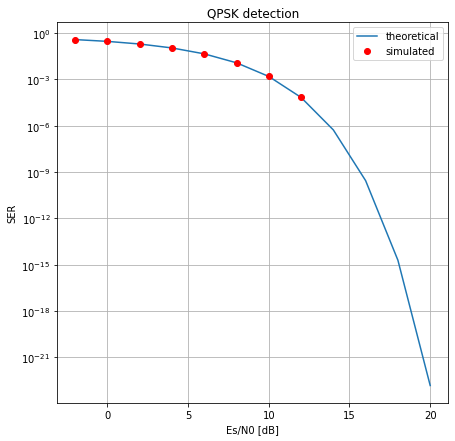

In [6]:
# Plot Es/N0 versus BER values.
fig = plt.figure(figsize=(7,7))
plt.plot(EsN0dB, ser_theo, label='theoretical')
plt.plot(EsN0dB, ser_simu, 'ro', label='simulated')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Es/N0 [dB]')
plt.ylabel('SER')
plt.grid(True)
plt.title('QPSK detection')
plt.legend()
#plt.xlim([-10, 10])
#plt.ylim([1e-5, 1])
plt.show()